my_translator
=

<br><br>

# 목차
## 1. 목표 및 의의
## 2. 이론
## 3. 코드
## 4. 회고

<br>

# 1. 목표 및 의의
## 1) Transformer를 낱낱히 뜯어본다.
## 2) 스스로 사용할만한 번역기에 도전해본다...!!

<br>

# 2. 이론
## Transformer

<br>

# 3. 코드

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


In [2]:
!nvidia-smi

Mon Jan 10 08:11:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   22C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화


print(tf.__version__)

2.4.1


In [4]:
def positional_encoding(pos_len, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos_len)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:,0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:,1::2])
    return sinusoid_table
    

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scale_dot_product_attention(self, Q, K, V, mask=None):
        d_k = tf.cast(K.shape[-1], tf.float32)
        # scaled qk 구하기

        QK_T = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK_T / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, *xs): # num_heads는 self에 있으니까 받을 필요 없음
        # MultiHead에 넣을려고 분할
        # x: [ batch x length x embedding_dimension ]
        # return: [ batch x heads x length x embedding_dimension]
        split_xs = []
        for x in xs:
            a,b,c = x.shape

            split_x = tf.reshape(x,(a,b,self.num_heads,self.depth))
            split_x = tf.transpose(split_x, (0,2,1,3))            
            split_xs.append(split_x)
            
        return split_xs


    def combine_heads(self, x):
        # 분할 계산을 마치고, 임베딩을 다시 결합한다.
        # x: [ batch x heads x length x depth ]
        # return: [ batch x length x emb ]
        x = tf.transpose(x,(0,2,1,3))
        a,b,c,d = x.shape

        concat_x = tf.reshape(x, (a,b,c*d))

        return concat_x


    def call(self, Q, K, V, mask=None): #[batch x len x 512 ]
        # 1: Linear_in(Q,K,V) -> WQ, WK, WV
        wq = self.W_q(Q)
        wk = self.W_k(K)
        wv = self.W_v(V)

        # 2: split heads
        W_qkv_split = self.split_heads(wq,wk,wv)

        # 3: scaled dot product attention
        out, attention_weights = self.scale_dot_product_attention(*W_qkv_split, mask)

        # 4: Combine Heads(out) -> out
        out = self.combine_heads(out)

        # 5: Linear_out(out) -> out
        out = self.linear(out)

        return out, attention_weights



In [6]:
class Position_wise_FFN(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(Position_wise_FFN, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self,x):
        out = self.w_1(x)
        out = self.w_2(out)
        return out


In [7]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = Position_wise_FFN(d_model,d_ff)

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask, training=False):
        # Multi-Head Attention
        residual = x

        out = self.norm1(x)
        out, enc_attn = self.enc_self_attn(out,out,out, mask)
        out = self.dropout(out, training=training)

        out += residual

        # position wise FFN
        residual2 = out
        out = self.norm2(out)
        out = self.ffn(out)
        out = self.dropout(out, training=training)
        out += residual2

        return out, enc_attn



In [8]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.dec_attn = MultiHeadAttention(d_model, n_heads)

        self.ffn = Position_wise_FFN(d_model,dff)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x,y, causality_mask, padding_mask, training=False):
        residual = x
        out = self.norm1(x)
        out, dec_attn = self.dec_self_attn(out,out,out, padding_mask)
        out = self.dropout(out, training=training)
        out += residual

        residual = out
        out = self.norm2(out)
        out, dec_enc_attn = self.dec_attn(out,y,y, causality_mask)
        out = self.dropout(out, training=training)
        out += residual

        residual = out
        out = self.norm3(out)
        out = self.ffn(out)
        out = self.dropout(out, training=training)
        out += residual

        return out, dec_attn, dec_enc_attn



In [9]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 dff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model,n_heads,dff,dropout) for _ in range(n_layers)]

    def call(self, x, mask, training=False):
        out = x

        enc_attns = []

        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask, training)
            enc_attns.append(enc_attn)

        return out, enc_attns
        

In [10]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, dff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model,n_heads, dff, dropout) for i in range(n_layers)]

    def call(self, x, enc_out, causality_mask, padding_mask, training=False):
        out = x
        
        dec_attns = []
        dec_enc_attns = []

        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out,enc_out, causality_mask, padding_mask, training)
            
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns
        

In [11]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers,d_model,
                 n_heads,dff,src_vocab_size,
                 tgt_vocab_size, pos_len,
                 dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_embedding = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_embedding = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.positional = positional_encoding(pos_len,d_model)

        self.encoder = Encoder(n_layers, d_model, n_heads, dff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, dff, dropout)
        
        self.out_linear = tf.keras.layers.Dense(tgt_vocab_size)
        self.dropout = dropout

        self.shared = shared

        if shared: self.out_linear.set_weights(tf.transpose(self.dec_embedding.weights))

    
    def embedding(self, emb, x):
        # share?
        seq_len = x.shape[1]
        out = emb(x)
        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.positional[np.newaxis, ...][:, :seq_len, :]

        return out

    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # 1 embedding
        enc = self.embedding(self.enc_embedding, enc_in)
        dec = self.embedding(self.dec_embedding, dec_in)

        # 2 encoder, decoder
        enc_out, enc_attns = self.encoder(enc, enc_mask)

        dec_out, dec_attns, dec_enc_attns = self.decoder(dec, enc_out, causality_mask, dec_mask)

        logits = self.out_linear(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns



In [12]:

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask


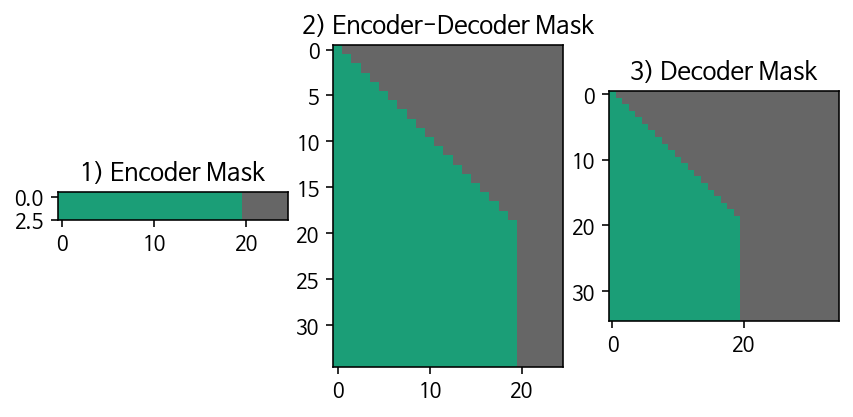

In [13]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [14]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)



In [15]:
now_path = "aiffel/Data/kor_en/"
path_to_enfile = "data/kor_en/korean-english-park.train.en"
path_to_kofile = "data/kor_en/korean-english-park.train.ko"
kor_path = now_path + path_to_enfile
eng_path = now_path + path_to_kofile

In [16]:

# 데이터 정제
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.readlines()
    with open(eng_path, "r") as f: eng = f.readlines()
    assert len(kor) == len(eng)
    print(len(kor))
    
    dataset = set()
    for i,j in zip(kor, eng):
        i = preprocess_sentence(i)
        j = preprocess_sentence(j)
        dataset.add((i,j))
    print(len(dataset))
    cleaned_corpus = list(dataset)
    return cleaned_corpus

In [17]:
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'([?!,."])', r' \1 ',sentence)
    sentence = re.sub(r'[^A-zㄱ-ㅎㅏ-ㅣ가-힣0-9?!,."]', ' ', sentence)
    sentence = re.sub(r'[" "]+', ' ',sentence)
    sentence = sentence.strip()
    return sentence

cleaned_corpus = clean_corpus(kor_path, eng_path)


94123
78931


In [18]:
import sentencepiece as spm
import os

def generate_tokenizer(corpus,
                       vocab_size,
                       lang="ko",
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):
    path = 'aiffel/Data/Model/transformer/'
    temp_file = f'{path}corpus_{lang}.temp'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix={path}spm_{lang} --vocab_size={vocab_size} --model_type=bpe'
    )
    
    s = spm.SentencePieceProcessor()
    s.Load(f'{path}spm_{lang}.model')
    print(f"{lang}-dict_num: {20000}")

    return s

In [19]:
eng, kor = zip(*cleaned_corpus)
print(kor[0])
ko = generate_tokenizer(kor,20000)
en = generate_tokenizer(eng,20000, lang="en")

china adopts more humane method for the death penalty 중국 , 인도적인 사형 방법 도입 200806 . 01
ko-dict_num: 20000
en-dict_num: 20000


In [20]:
def tokenize(corpus, tensorlen,voca_size):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=voca_size,filters='',)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=tensorlen)

    return tensor, tokenizer

In [21]:

path = 'aiffel/Data/Model/transformer/'
temp_file = f'{path}corpus_ko.temp'
ko_seq = []
with open(temp_file,'r') as f:
    for i in f.readlines():
        ko_seq.append(ko.SampleEncodeAsPieces(i,1, 0.0))
ko_tensor, ko_tokenizer = tokenize(ko_seq,50,20000)
print(ko_seq[0])
en_seq = []
temp_file = f'{path}corpus_en.temp'
with open(temp_file,'r') as f:
    for i in f.readlines():
        en_seq.append(en.SampleEncodeAsPieces(i,1, 0.0))
en_tensor, en_tokenizer = tokenize(en_seq,50,20000)
print(en_seq[0])

['▁china', '▁ad', 'op', 'ts', '▁more', '▁human', 'e', '▁me', 'th', 'od', '▁for', '▁the', '▁death', '▁pen', 'al', 'ty', '▁중국', '▁,', '▁인도', '적인', '▁사형', '▁방법', '▁도입', '▁200806', '▁.', '▁01']
['▁provisional', '▁results', '▁had', '▁given', '▁victory', '▁to', '▁the', '▁people', '▁power', '▁party', '▁ppp', '▁,', '▁with', '▁23', '3', '▁of', '▁the', '▁480', '▁available', '▁seats', '▁.']


In [22]:
print(f"ko dict voca: {len(ko_tokenizer.index_word)}")
print(f"en dict voca: {len(en_tokenizer.index_word)}")


ko dict voca: 20288
en dict voca: 19066


In [23]:
print(len(ko_seq), len(en_seq))
print(ko_seq[1], en_seq[1])

78931 78931
['▁현재', '▁쿠', '스', '꼬', '는', '▁페루', '▁북서', '쪽', '▁약', '▁64', 'km', '에', '▁있는', '▁밀림', '▁속', '▁마', '추', '픽', '추', '▁유적', '지와', '▁더불어', '▁페루', '의', '▁주요', '▁관광', '지다', '▁.'] ['▁today', '▁,', '▁cuzco', '▁is', '▁peru', '▁s', '▁main', '▁tourism', '▁hub', '▁and', '▁a', '▁launching', '▁point', '▁for', '▁visitors', '▁to', '▁the', '▁jungle', '▁shroud', 'ed', '▁ruins', '▁of', '▁mach', 'u', '▁pic', 'ch', 'u', '▁,', '▁40', '▁miles', '▁northwest', '▁.']


In [24]:
en_tensor.shape

(78931, 50)

## 이렇게 케라스 토크나이저를 쓸 수도 있지만, 한번 sentencepiece를 조금 더 사용해보겠습니다.

In [25]:
def senten_tokenize(kor,eng, ko_model,en_model, max_len):
    kos = []
    ens = []
    for i,j in zip(kor,eng):
        i = preprocess_sentence(i)
        j = preprocess_sentence(j)
        ko = ko_model.EncodeAsIds(i)
        en = en_model.EncodeAsIds(j)
        if len(ko)>48 or len(en)>48: continue
        kos.append(ko)
        ens.append(en)
    ko_tensor = tf.keras.preprocessing.sequence.pad_sequences(kos, padding='post',maxlen=max_len)
    en_tensor = tf.keras.preprocessing.sequence.pad_sequences(ens, padding='post',maxlen=max_len)

    return ko_tensor, en_tensor

## 학습을 해도해도 결과가 안나와서 보니, 여기 전처리를 잘못했더라구요.
## 모델도 중요하지만, 누가 대신해주는 거 없으니, 정신 똑바로 차려야하겠습니다!

### decoder쪽 토그나이저는 set_encode_extra_options("bos:eos")을 해주어 시작, 끝 토큰을 추가할 수 있습니다.
### 

In [26]:
en.set_encode_extra_options("bos:eos")
ko_tensor,en_tensor = senten_tokenize(kor,eng, ko,en, 50)

In [27]:
from sklearn.model_selection import train_test_split

BUFFER_SIZE = 128
BATCH_SIZE = 128

enc_train, enc_val, dec_train, dec_val = \
train_test_split(ko_tensor, en_tensor, test_size=0.2) # 하... 여기 영어랑 한국어 순서 바뀌어 있었다..





dataset = tf.data.Dataset.from_tensor_slices((enc_train,dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))

dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((128, 50), (128, 50)), types: (tf.int32, tf.int32)>


<BatchDataset shapes: ((128, 50), (128, 50)), types: (tf.int32, tf.int32)>

In [28]:
train = dataset.__iter__()


In [29]:
a = next(train)[0]
print(a)

tf.Tensor(
[[  132 19422 18810 ...     0     0     0]
 [ 4955 18848 14651 ...     0     0     0]
 [ 2971 18765  4133 ...     0     0     0]
 ...
 [ 8557 18811  4674 ...     0     0     0]
 [ 3468  1884  3470 ...     0     0     0]
 [  308   322  9008 ...     0     0     0]], shape=(128, 50), dtype=int32)


In [30]:
transformer = Transformer(4,512,4,2048,20289,20001,50,shared=False)

# 와... 위대하다.
### 여기서 오류가 얼마나 떴는지 모르겠다.
### super은 init이라는 메소드가 없다는 부분부터, pos가 정의되지 않았다는 내용 등등. 설계를 똑바로 하니, 틀린부분이 어디인지 알아서 찾아준다는 점이 아주 뿌듯하다.

In [31]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [32]:
# ex = '''오바마는 대통령이다.
# 시민들은 도시 속에 산다.
# 커피는 필요 없다.
# 일곱 명의 사망자가 발생했다.'''
# ex = ex.split('\n')
# corpus = []
# for i in ex:
#     corpus.append(ko.SampleEncodeAsPieces(i,1, 0.0))
# for i in corpus:
#     print(i)
# tensor = ko_tokenizer.texts_to_sequences(corpus)

# tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=50)
# print(tensor)


In [30]:

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

## 문장이 짧아서 오히려 잘 안될지도 모른다는 걱정이 들지만, 논리적이지 않은 걱정인 것 같습니다..ㅎㅎ

In [40]:
transformer = Transformer(6,512,4,2048,20001,20001,50,shared=False)


In [41]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time


BUFFER_SIZE = 128
BATCH_SIZE = 128

enc_train, enc_val, dec_train, dec_val = \
train_test_split(ko_tensor, en_tensor, test_size=0.2)





dataset = tf.data.Dataset.from_tensor_slices((enc_train,dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))

dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset



@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns




@tf.function()
def eval_step(src,tgt, model):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src,tgt)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(src,tgt,enc_mask, dec_enc_mask, dec_mask)
    val_loss = loss_function(gold, predictions[:, :-1])
    
    
    return val_loss, enc_attns, dec_attns, dec_enc_attns



<BatchDataset shapes: ((128, 50), (128, 50)), types: (tf.int32, tf.int32)>


In [42]:

EPOCHS = 15



for epoch in range(EPOCHS):
    total_loss = 0
    val_loss = 0
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))[:-2]
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    train = dataset.__iter__()
    val = val_dataset.__iter__()

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(*next(train),
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))


    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))[:-2]
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            eval_step(*next(val),
                       transformer)
        
        val_loss += batch_loss
        
        t.set_description_str('Val_Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Val_loss %.4f' % (val_loss.numpy() / (batch + 1)))

    for ex in examples:
        translate(ex, transformer, ko, en)
    time.sleep(2)




Val_Epoch  1: 100%|██████████| 113/113 [01:03<00:00,  1.79it/s, Val_loss 6.5562]


Input: 오바마는 대통령이다.
Predicted translation: the the the the the , the , the , the .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is the the the , the
Input: 커피는 필요 없다.
Predicted translation: the is the the the , the
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the the the the , the


Val_Epoch  2: 100%|██████████| 113/113 [01:00<00:00,  1.86it/s, Val_loss 6.0535]


Input: 오바마는 대통령이다.
Predicted translation: the the situation , the new new lot of the united states .
Input: 시민들은 도시 속에 산다.
Predicted translation: the new korean korean of the country .
Input: 커피는 필요 없다.
Predicted translation: the dow is not the new new lot of the new new new country .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the new korean korean of the country .


Val_Epoch  3: 100%|██████████| 113/113 [01:00<00:00,  1.87it/s, Val_loss 5.7525]


Input: 오바마는 대통령이다.
Predicted translation: obama , the nomination .
Input: 시민들은 도시 속에 산다.
Predicted translation: the man was a second .
Input: 커피는 필요 없다.
Predicted translation: i re a kind of the same .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the suicide wounded wounded at the wounded .


Val_Epoch  4: 100%|██████████| 113/113 [01:00<00:00,  1.86it/s, Val_loss 5.5600]


Input: 오바마는 대통령이다.
Predicted translation: i is a lot of the democratic democratic democratic democratic party .
Input: 시민들은 도시 속에 산다.
Predicted translation: the man is a good .
Input: 커피는 필요 없다.
Predicted translation: i can do going to be .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two people were injured .


Val_Epoch  5: 100%|██████████| 113/113 [01:00<00:00,  1.86it/s, Val_loss 5.4770]


Input: 오바마는 대통령이다.
Predicted translation: obama , obama cnn  ⁇ 
Input: 시민들은 도시 속에 산다.
Predicted translation: the truth is not be .
Input: 커피는 필요 없다.
Predicted translation: it is a lot of the situation .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the wounded was killed .


Val_Epoch  6: 100%|██████████| 113/113 [01:00<00:00,  1.87it/s, Val_loss 5.3235]


Input: 오바마는 대통령이다.
Predicted translation: president george obama , obama , and president bush .
Input: 시민들은 도시 속에 산다.
Predicted translation: the cause of the planet .
Input: 커피는 필요 없다.
Predicted translation: i can be safe .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two people were killed .


Val_Epoch  7: 100%|██████████| 113/113 [01:00<00:00,  1.86it/s, Val_loss 5.2956]


Input: 오바마는 대통령이다.
Predicted translation: obama president george obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the indian panda is now .
Input: 커피는 필요 없다.
Predicted translation: i can t be able to be a very dangerous .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people were killed .


Val_Epoch  8: 100%|██████████| 113/113 [01:00<00:00,  1.88it/s, Val_loss 5.2840]


Input: 오바마는 대통령이다.
Predicted translation: obama is a president  ⁇ 
Input: 시민들은 도시 속에 산다.
Predicted translation: the poison rooted is rooted .
Input: 커피는 필요 없다.
Predicted translation: if you can be rid of course .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people were wounded .


Val_Epoch  9: 100%|██████████| 113/113 [01:00<00:00,  1.86it/s, Val_loss 5.2648]


Input: 오바마는 대통령이다.
Predicted translation: president obama is president bush .
Input: 시민들은 도시 속에 산다.
Predicted translation: the elephants are in the midst of the city of the city of hindu city .
Input: 커피는 필요 없다.
Predicted translation: if you can you you you you you you you you .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people were killed .


Val_Epoch 10: 100%|██████████| 113/113 [01:00<00:00,  1.87it/s, Val_loss 5.3066]


Input: 오바마는 대통령이다.
Predicted translation: the president is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the indian is rooted .
Input: 커피는 필요 없다.
Predicted translation: if you can .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least seven people were killed .


Val_Epoch 11: 100%|██████████| 113/113 [01:00<00:00,  1.87it/s, Val_loss 5.3883]


Input: 오바마는 대통령이다.
Predicted translation: obama , who is president bush , president , obama , president , obama , is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the threatens rooted in the middle of the middle .
Input: 커피는 필요 없다.
Predicted translation: if you can store
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people were killed .


Val_Epoch 12: 100%|██████████| 113/113 [01:00<00:00,  1.87it/s, Val_loss 5.5044]


Input: 오바마는 대통령이다.
Predicted translation: obama is one of obama s inauguration .
Input: 시민들은 도시 속에 산다.
Predicted translation: hundreds of people are in the park .
Input: 커피는 필요 없다.
Predicted translation: if you can be able to ban .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Val_Epoch 13: 100%|██████████| 113/113 [01:00<00:00,  1.87it/s, Val_loss 5.6656]


Input: 오바마는 대통령이다.
Predicted translation: he s a dream of care , he told illinois , february care in indiana care .
Input: 시민들은 도시 속에 산다.
Predicted translation: 82 year old kerts .
Input: 커피는 필요 없다.
Predicted translation: improve , ban is more more .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Val_Epoch 14: 100%|██████████| 113/113 [01:00<00:00,  1.86it/s, Val_loss 5.7954]


Input: 오바마는 대통령이다.
Predicted translation: he is welcoming obama s lead in february .
Input: 시민들은 도시 속에 산다.
Predicted translation: some of the fires are collapsed .
Input: 커피는 필요 없다.
Predicted translation: improve coffee is not matched .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Val_Epoch 15: 100%|██████████| 113/113 [01:00<00:00,  1.88it/s, Val_loss 5.9435]


Input: 오바마는 대통령이다.
Predicted translation: obama s annual october 29th .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the past week .
Input: 커피는 필요 없다.
Predicted translation: improve your product is .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were injured .


In [43]:
checkpoint_dir = "/aiffel/Data/Model/transformer/weight"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(transformer=transformer)

checkpoint.save(file_prefix=checkpoint_prefix)


'/aiffel/Data/Model/transformer/weight/ckpt-1'

In [31]:
from tqdm import tqdm

class Transformer(tf.keras.Model):
    def __init__(self, n_layers,d_model,
                 n_heads,dff,src_vocab_size,
                 tgt_vocab_size, pos_len, loss_function,
                 dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_embedding = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_embedding = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.positional = positional_encoding(pos_len,d_model)

        self.encoder = Encoder(n_layers, d_model, n_heads, dff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, dff, dropout)
        
        self.out_linear = tf.keras.layers.Dense(tgt_vocab_size)
        self.dropout = tf.keras.layers.SpatialDropout1D(dropout/2)

        self.shared = shared
        self.history = {'loss':[],'val_loss':[], 'attention':[]}

        self.loss_function = loss_function

        if shared: self.out_linear.set_weights(tf.transpose(self.dec_embedding.weights)) # 이런 생각을 한다는 것이 매우 놀랍다.

    
    def embedding(self, emb, x,training=False):
        # share?
        seq_len = x.shape[1]
        out = emb(x)
        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.positional[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out, training=training)

        return out

    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask, training=False):
        # 1 embedding
        enc = self.embedding(self.enc_embedding, enc_in, training)
        dec = self.embedding(self.dec_embedding, dec_in, training)

        # 2 encoder, decoder
        enc_out, enc_attns = self.encoder(enc, enc_mask, training)

        dec_out, dec_attns, dec_enc_attns = self.decoder(dec, enc_out, causality_mask, dec_mask, training)

        logits = self.out_linear(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns
    
    def generate_padding_mask(self, seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return seq[:, tf.newaxis, tf.newaxis, :]

    def generate_causality_mask(self, src_len, tgt_len):
        mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
        return tf.cast(mask, tf.float32)

    def generate_masks(self, src, tgt):
        enc_mask = self.generate_padding_mask(src)
        dec_mask = self.generate_padding_mask(tgt)

        dec_enc_causality_mask = self.generate_causality_mask(tgt.shape[1], src.shape[1])
        dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

        dec_causality_mask = self.generate_causality_mask(tgt.shape[1], tgt.shape[1])
        dec_mask = tf.maximum(dec_mask, dec_causality_mask)

        return enc_mask, dec_enc_mask, dec_mask

    @tf.function()
    def train_step(self, src, tgt, optimizer):
        gold = tgt[:, 1:]
            
        enc_mask, dec_enc_mask, dec_mask = self.generate_masks(src, tgt)

        with tf.GradientTape() as tape:
            predictions, enc_attns, dec_attns, dec_enc_attns = self(src, tgt, enc_mask, dec_enc_mask, dec_mask, training=True)
            loss = self.loss_function(gold, predictions[:, :-1])

        gradients = tape.gradient(loss, self.trainable_variables)    
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return loss, enc_attns, dec_attns, dec_enc_attns




    @tf.function()
    def eval_step(self, src,tgt):
        gold = tgt[:, 1:]

        enc_mask, dec_enc_mask, dec_mask = self.generate_masks(src,tgt)

        predictions, enc_attns, dec_attns, dec_enc_attns = self(src,tgt,enc_mask, dec_enc_mask, dec_mask)
        val_loss = self.loss_function(gold, predictions[:, :-1])
        
        
        return val_loss, enc_attns, dec_attns, dec_enc_attns


    def fit(self, epochs=20, x_train=None, y_train=None,
            x_val=None, y_val=None, BATCH_SIZE=128, 
            offset_epoch=0, translate=None, examples=None):
        EPOCHS = epochs

        for epoch in range(EPOCHS):
            total_loss = 0
            val_loss = 0
            idx_list = list(range(0, x_train.shape[0], BATCH_SIZE))
            random.shuffle(idx_list)
            t = tqdm(idx_list)

            for (batch, idx) in enumerate(t):
                batch_loss, enc_attns, dec_attns, dec_enc_attns = \
                self.train_step(x_train[idx:idx+BATCH_SIZE],
                                y_train[idx:idx+BATCH_SIZE],
                                optimizer)

                total_loss += batch_loss
                
                t.set_description_str('Epoch %2d' % (offset_epoch+epoch + 1))
                t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            self.history['loss'].append(total_loss.numpy() / (batch + 1))

            if x_val is not None:
                idx_list = list(range(0, x_val.shape[0], BATCH_SIZE))[:-2]
                random.shuffle(idx_list)
                t = tqdm(idx_list)

                for (batch, idx) in enumerate(t):
                    batch_loss, enc_attns, dec_attns, dec_enc_attns = \
                        self.eval_step(x_val[idx:idx+BATCH_SIZE],
                                    y_val[idx:idx+BATCH_SIZE])
                    
                    val_loss += batch_loss
                    
                    t.set_description_str('Val_epoch %2d' % (offset_epoch+epoch + 1))
                    t.set_postfix_str('Val_loss %.4f' % (val_loss.numpy() / (batch + 1)))
                self.history['val_loss'].append(val_loss.numpy() / (batch + 1))

            if examples and translate:
                for ex in examples:
                    translate(ex, transformer, ko, en)
                time.sleep(2)

        self.history['attention'].extend([enc_attns, dec_attns, dec_enc_attns])
        return self.history


class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [32]:
transformer = Transformer(n_layers=4, d_model=512, n_heads=4, dff=2048, 
                          src_vocab_size=20000, tgt_vocab_size=20000, 
                          pos_len=50, loss_function=loss_function, dropout=0.4, shared=False)

In [33]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time


BATCH_SIZE = 256

enc_train, enc_val, dec_train, dec_val = \
train_test_split(ko_tensor, en_tensor, test_size=0.1)


examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다.",
            "심심해서 당신이 보고싶다."
]

Thanks = transformer.fit(10, enc_train, dec_train, enc_val, dec_val, BATCH_SIZE, translate=translate, examples=examples)

Val_epoch  1: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s, Val_loss 7.0056]


Input: 오바마는 대통령이다.
Predicted translation: the the the . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the .
Input: 커피는 필요 없다.
Predicted translation: the the the . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the the . . .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the the the the the .


Val_epoch  2: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 6.8395]


Input: 오바마는 대통령이다.
Predicted translation: the the the . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the . . .
Input: 커피는 필요 없다.
Predicted translation: the the the . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the the . . .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the the the the . .


Val_epoch  3: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 6.7998]


Input: 오바마는 대통령이다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the .
Input: 커피는 필요 없다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the 

Val_epoch  4: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 6.6455]


Input: 오바마는 대통령이다.
Predicted translation: the dow of the be
Input: 시민들은 도시 속에 산다.
Predicted translation: the the united , the the the the the the the the world .
Input: 커피는 필요 없다.
Predicted translation: the the world of the be
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the united states of the the the the be the be the world .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the the united , the the the the the the world .


Val_epoch  5: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 6.6536]


Input: 오바마는 대통령이다.
Predicted translation: the dow is the end of the be the end .
Input: 시민들은 도시 속에 산다.
Predicted translation: the dow is the end .
Input: 커피는 필요 없다.
Predicted translation: the dow is the end of the be the end .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dow is the end of the be the end .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the dow is the first world .


Val_epoch  6: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 6.3553]


Input: 오바마는 대통령이다.
Predicted translation: the dow is the first korean the first korean the first korean the united states .
Input: 시민들은 도시 속에 산다.
Predicted translation: but the dow is the be the first korean be the first korean be korean the united states .
Input: 커피는 필요 없다.
Predicted translation: but he was t been t been t been t t very be the be the be the be the end .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dow is the first korean the first korean the first korean the united states to be the end it was the end .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the dow is the first korean the united states to be the end .


Val_epoch  7: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it, Val_loss 6.1752]


Input: 오바마는 대통령이다.
Predicted translation: the dow is a lot of the world s end to be a nuclear nomination .
Input: 시민들은 도시 속에 산다.
Predicted translation: the dow is the world .
Input: 커피는 필요 없다.
Predicted translation: he was not to be be a lot .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dow was expected to meet the united states s nuclear nuclear nuclear nuclear nuclear nuclear nuclear nuclear korean korean korean korean korean korean korean korean korean korean korean korean korean korean korean korean korean nuclear nuclear nuclear nuclear nuclear nuclear nuclear korean korean korean korean weapons .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the dow is the world of the world .


Val_epoch  8: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 6.0466]


Input: 오바마는 대통령이다.
Predicted translation: the korea herald .
Input: 시민들은 도시 속에 산다.
Predicted translation: the dow is a lot of the world s be a lot of the world s end it is the first be half it s be a lead it s be a be half the economy .
Input: 커피는 필요 없다.
Predicted translation: the ap .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dow were killed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the ap correspondent .


Val_epoch  9: 100%|██████████| 27/27 [00:18<00:00,  1.44it/s, Val_loss 5.9298]


Input: 오바마는 대통령이다.
Predicted translation: the white house says the senate is a candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: but the ap , the ap , is a new first half .
Input: 커피는 필요 없다.
Predicted translation: but you is going to be a lot .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the government has been reported .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the ap s ap .


Val_epoch 10: 100%|██████████| 27/27 [00:19<00:00,  1.40it/s, Val_loss 5.7177]


Input: 오바마는 대통령이다.
Predicted translation: obama is a very time of the white house .
Input: 시민들은 도시 속에 산다.
Predicted translation: the ap s mark is a lot of the world s largest press .
Input: 커피는 필요 없다.
Predicted translation: we don t know we re sorry to do you re .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the government herald reports it was no estimated least least least least least least least least least least least least least least least least least least least least least least least least least least least least least least least least least least 750 people .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the ap s mark smith ⁇ 


In [34]:
checkpoint_dir = "/aiffel/Data/Model/transformer/weight"

checkpoint_prefix = os.path.join(checkpoint_dir, "uplayer4")
checkpoint = tf.train.Checkpoint(transformer=transformer)

checkpoint.save(file_prefix=checkpoint_prefix)

'/aiffel/Data/Model/transformer/weight/uplayer4-1'

In [35]:
Thanks = transformer.fit(10, enc_train, dec_train, enc_val, dec_val, BATCH_SIZE, translate=translate, examples=examples, offset_epoch=10)

checkpoint_dir = "/aiffel/Data/Model/transformer/weight"

checkpoint_prefix = os.path.join(checkpoint_dir, "uplayer4-2")
checkpoint = tf.train.Checkpoint(transformer=transformer)

checkpoint.save(file_prefix=checkpoint_prefix)

Val_epoch 11: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 5.6006]


Input: 오바마는 대통령이다.
Predicted translation: obama s obama times .
Input: 시민들은 도시 속에 산다.
Predicted translation: the cause of the planet .
Input: 커피는 필요 없다.
Predicted translation: if you can be able to be able to be able to be .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the cause of the blast were killed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: i think you re a lot of your own your own .


Val_epoch 12: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 5.5729]


Input: 오바마는 대통령이다.
Predicted translation: the president elect elect elect elect elect elect sauger bak moo candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: the ap s jason correspondent station has been killed .
Input: 커피는 필요 없다.
Predicted translation: it s not a very time .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the blasts occurred the dead of the town of the town of the outskirts of the town of the town of the town of the town of the town .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the ap s jerry bodlander old correspondent jerry bodlander .


Val_epoch 13: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 5.3919]


Input: 오바마는 대통령이다.
Predicted translation: the senator s mark smith senator reports he was too a new first time .
Input: 시민들은 도시 속에 산다.
Predicted translation: the storm was a bit of the storm .
Input: 커피는 필요 없다.
Predicted translation: it s not a lot of the problem .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the storm was destroyed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the ap s mark smith


Val_epoch 14: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 5.3217]


Input: 오바마는 대통령이다.
Predicted translation: obama has been a new aide for barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the ap s jason correspondent has been found .
Input: 커피는 필요 없다.
Predicted translation: it s not a lot of people .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the official reports the associated press this week .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the ap s bryant thomas thomas says it s not a good friend .


Val_epoch 15: 100%|██████████| 27/27 [00:18<00:00,  1.42it/s, Val_loss 5.3720]


Input: 오바마는 대통령이다.
Predicted translation: obama s campaign has a tough debate .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are still trying to get a fire .
Input: 커피는 필요 없다.
Predicted translation: it s not a lot of people .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the blast occurred at least 11 , 000 people and the capital of the capital of the capital of the capital of peshawar .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the ap s sauger magoni


Val_epoch 16: 100%|██████████| 27/27 [00:19<00:00,  1.42it/s, Val_loss 5.1729]


Input: 오바마는 대통령이다.
Predicted translation: obama is also a very popular aide .
Input: 시민들은 도시 속에 산다.
Predicted translation: the woman was carrying a large man .
Input: 커피는 필요 없다.
Predicted translation: it s a lot of brain .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll in the philippines suburb of the capital province suburb , killing at least 1 , 800 people were killed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the ap s jason reed


Val_epoch 17: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 5.1515]


Input: 오바마는 대통령이다.
Predicted translation: obama says he was disappointed .
Input: 시민들은 도시 속에 산다.
Predicted translation: the woman s death toll .
Input: 커피는 필요 없다.
Predicted translation: it s a little bit .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the protesters were killed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the ap s jason correspondent sagar meghani .


Val_epoch 18: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s, Val_loss 5.0165]


Input: 오바마는 대통령이다.
Predicted translation: obama has been undergoing barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the two people were injured .
Input: 커피는 필요 없다.
Predicted translation: it s not a good fix .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was destroyed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: it s a good time .


Val_epoch 19: 100%|██████████| 27/27 [00:19<00:00,  1.41it/s, Val_loss 5.0867]


Input: 오바마는 대통령이다.
Predicted translation: obama s campaign has a chance to obama s campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: the street is the only one of the most unusual buildings .
Input: 커피는 필요 없다.
Predicted translation: it s not a lot of heart .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deadliest attack in the town of the country s deadliest history .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the ap s rita foley is not a tricky class .


Val_epoch 20: 100%|██████████| 27/27 [00:18<00:00,  1.44it/s, Val_loss 5.0159]


Input: 오바마는 대통령이다.
Predicted translation: obama s campaign is a new president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the street is a huge part of the street .
Input: 커피는 필요 없다.
Predicted translation: it s not a good fix .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was reported .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the ap s jason gramm reports about the age of the story


'/aiffel/Data/Model/transformer/weight/uplayer4-2-1'

In [36]:
Thanks = transformer.fit(10, enc_train, dec_train, enc_val, dec_val, BATCH_SIZE, translate=translate, examples=examples, offset_epoch=20)

checkpoint_dir = "/aiffel/Data/Model/transformer/weight"

checkpoint_prefix = os.path.join(checkpoint_dir, "uplayer4-3")
checkpoint = tf.train.Checkpoint(transformer=transformer)

checkpoint.save(file_prefix=checkpoint_prefix)

Val_epoch 21: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 5.0457]


Input: 오바마는 대통령이다.
Predicted translation: obama has been a good supporter of the obama administration .
Input: 시민들은 도시 속에 산다.
Predicted translation: the protesters were crowded .
Input: 커피는 필요 없다.
Predicted translation: it s not a lot of brain .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: more than least 200 people were killed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the idea of the experiment is a problem .


Val_epoch 22: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s, Val_loss 4.9712]


Input: 오바마는 대통령이다.
Predicted translation: obama ⁇ s elected national nominee barack obama says he wants to reverse whether he wants to reverse the president elect s job .
Input: 시민들은 도시 속에 산다.
Predicted translation: the roof of the kitchen was a small city .
Input: 커피는 필요 없다.
Predicted translation: it s not a lot of brain .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least 61 people were killed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: the bad consideration is that the bad .


Val_epoch 23: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 4.9806]


Input: 오바마는 대통령이다.
Predicted translation: obama ⁇ s rogue president elect barack obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the protesters were furious .
Input: 커피는 필요 없다.
Predicted translation: it s not a lot of fun .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least 15 people have been killed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: and you know you ll be able to get a personal job .


Val_epoch 24: 100%|██████████| 27/27 [00:18<00:00,  1.44it/s, Val_loss 4.9941]


Input: 오바마는 대통령이다.
Predicted translation: obama s campaign has a new president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the rally was a huge night .
Input: 커피는 필요 없다.
Predicted translation: it s not a lot of people .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was blamed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: you know you re gonna be a sociator .


Val_epoch 25: 100%|██████████| 27/27 [00:19<00:00,  1.42it/s, Val_loss 4.9507]


Input: 오바마는 대통령이다.
Predicted translation: obama has been elected .
Input: 시민들은 도시 속에 산다.
Predicted translation: the protesters are packed to be the first .
Input: 커피는 필요 없다.
Predicted translation: it s not a lot of brain .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deadliest effect toll from the weekend .
Input: 심심해서 당신이 보고싶다.
Predicted translation: it s a simple sense of the story .


Val_epoch 26: 100%|██████████| 27/27 [00:18<00:00,  1.45it/s, Val_loss 4.9778]


Input: 오바마는 대통령이다.
Predicted translation: obama ⁇ s elected slam
Input: 시민들은 도시 속에 산다.
Predicted translation: the protesters were crowded .
Input: 커피는 필요 없다.
Predicted translation: it s not a good precedent .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deadliest effect toll from the u . s .
Input: 심심해서 당신이 보고싶다.
Predicted translation: otherwise , it s a good sense of fun .


Val_epoch 27: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s, Val_loss 4.9864]


Input: 오바마는 대통령이다.
Predicted translation: obama replied he wants to reverse whether he was going to reverse obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the protests are concentrated on the street .
Input: 커피는 필요 없다.
Predicted translation: it s not true .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was reported to be a week .
Input: 심심해서 당신이 보고싶다.
Predicted translation: you don t heard about your job .


Val_epoch 28: 100%|██████████| 27/27 [00:18<00:00,  1.44it/s, Val_loss 4.9920]


Input: 오바마는 대통령이다.
Predicted translation: obama has been elected president elect barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the rally is a day after the city s snow .
Input: 커피는 필요 없다.
Predicted translation: it s not a good problem .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least 23 people were killed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: otherwise , it s a good question .


Val_epoch 29: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 4.9930]


Input: 오바마는 대통령이다.
Predicted translation: obama is the first president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the protests are the worst internal city .
Input: 커피는 필요 없다.
Predicted translation: it s not a very good problem .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was concealed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: bad news for the concept of reaction to the simple .


Val_epoch 30: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 4.9860]


Input: 오바마는 대통령이다.
Predicted translation: obama s aides say they re lucky to reverse what he called on .
Input: 시민들은 도시 속에 산다.
Predicted translation: protesters were demolving .
Input: 커피는 필요 없다.
Predicted translation: it s not a good thing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was reported .
Input: 심심해서 당신이 보고싶다.
Predicted translation: you can see you to see you .


'/aiffel/Data/Model/transformer/weight/uplayer4-3-1'

In [37]:
Thanks = transformer.fit(3, enc_train, dec_train, enc_val, dec_val, BATCH_SIZE, translate=translate, examples=examples, offset_epoch=30)

checkpoint_dir = "/aiffel/Data/Model/transformer/weight"

checkpoint_prefix = os.path.join(checkpoint_dir, "uplayer4-4")
checkpoint = tf.train.Checkpoint(transformer=transformer)

checkpoint.save(file_prefix=checkpoint_prefix)

Val_epoch 31: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, Val_loss 5.0202]


Input: 오바마는 대통령이다.
Predicted translation: obama ⁇ s active
Input: 시민들은 도시 속에 산다.
Predicted translation: the protesters are riding to vote .
Input: 커피는 필요 없다.
Predicted translation: it s not a good thing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least 20 people were killed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: you can t see that .


Val_epoch 32: 100%|██████████| 27/27 [00:19<00:00,  1.41it/s, Val_loss 5.0162]


Input: 오바마는 대통령이다.
Predicted translation: obama ⁇ s a president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: protesters are staying in the midst of the city .
Input: 커피는 필요 없다.
Predicted translation: it s not a lot of brain .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least 15 people have died .
Input: 심심해서 당신이 보고싶다.
Predicted translation: you can tell you to do it .


Val_epoch 33: 100%|██████████| 27/27 [00:19<00:00,  1.41it/s, Val_loss 5.0151]


Input: 오바마는 대통령이다.
Predicted translation: obama s camp touted a second consecutive term
Input: 시민들은 도시 속에 산다.
Predicted translation: the protests are concentrated in the crucwing of the city .
Input: 커피는 필요 없다.
Predicted translation: it s not a good thing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least seven people have been killed .
Input: 심심해서 당신이 보고싶다.
Predicted translation: it s a good story .


'/aiffel/Data/Model/transformer/weight/uplayer4-4-1'

# 4. 회고
## 1) 이걸로 며칠을 보내버렸는지 모르겠다. 처음 학습을 돌리고, 왜 종료토큰을 학습하지 못하는지 의문이 들었는데, 종료토큰을 학습한 적이 없었기 때문이였다. 참.... 세상에 이유없는 일은 없는 것인지도 모른다는 생각이 들었다.
## 2) 내 아이가 언어를 익힌 것 같은 기쁨이 들었다.